In [10]:
!pip install kaggle

In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle

In [13]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:43<00:00, 21.4MB/s]
100% 2.29G/2.29G [01:43<00:00, 23.8MB/s]


In [14]:
!unzip -qq chest-xray-pneumonia.zip

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [16]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/chest_xray/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 5216 files belonging to 2 classes.


In [17]:
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/chest_xray/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 624 files belonging to 2 classes.


In [18]:
val_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/chest_xray/val',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 8,
    image_size = (256,256)
)

Found 16 files belonging to 2 classes.


In [19]:
class_names = train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [20]:
import numpy as np

for image, labels in val_ds:
  print(labels)
  class_labels=[class_names[i] for i in labels.numpy()]
  print(class_labels)

tf.Tensor([1 1 0 1 0 1 1 0], shape=(8,), dtype=int32)
['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL']
tf.Tensor([1 1 0 0 0 0 1 0], shape=(8,), dtype=int32)
['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL']


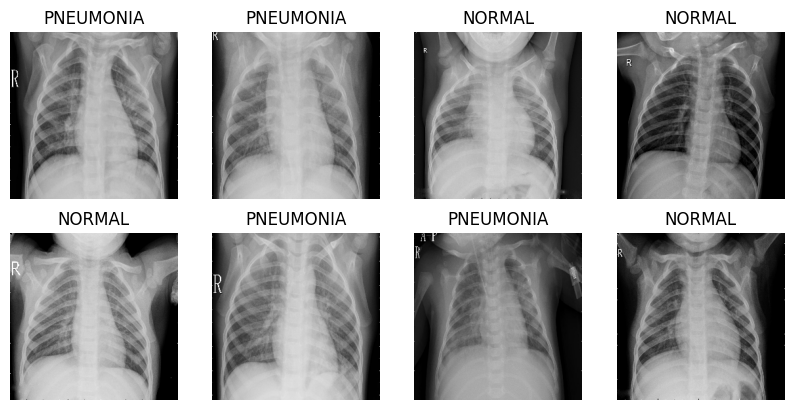

In [21]:
import matplotlib.pyplot as plt

def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

for images, labels in val_ds.take(1):
    plot_images(images, labels, class_names)


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 2.0],
    channel_shift_range=10,
    fill_mode='nearest',
)

In [23]:
def augment_images(images, labels):
    augmented_images = tf.py_function(
        lambda x, y: (datagen.flow(x, batch_size=len(x), shuffle=False).next(), y),
        (images, labels),
        (tf.float32, tf.int32)
    )
    return augmented_images

In [24]:
augmented_train_ds = train_ds.map(augment_images)
augmented_test_ds = test_ds.map(augment_images)
augmented_val_ds = val_ds.map(augment_images)

In [25]:
def plot_augmented_images(images, labels, class_names):
    num_images = len(images)
    num_rows = 4
    num_cols = 8

    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

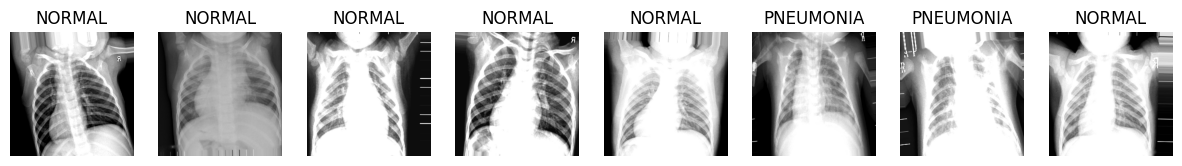

In [26]:
for images, labels in augmented_val_ds.take(1):
    plot_augmented_images(images, labels, class_names)

In [27]:
def process(image, label):
  image = tf.cast(image/255., tf.float32)
  return image, label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

In [30]:
model.add(Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

In [31]:
model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

In [32]:
model.add(Flatten())

In [33]:
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [35]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [36]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
163/163 [==============================] - 54s 259ms/step - loss: 0.9811 - accuracy: 0.9045 - val_loss: 28.8234 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 43s 253ms/step - loss: 0.3948 - accuracy: 0.9423 - val_loss: 18.5379 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 43s 250ms/step - loss: 0.1978 - accuracy: 0.9666 - val_loss: 9.3519 - val_accuracy: 0.6426
Epoch 4/10
163/163 [==============================] - 42s 246ms/step - loss: 0.1166 - accuracy: 0.9726 - val_loss: 7.5487 - val_accuracy: 0.6619
Epoch 5/10
163/163 [==============================] - 41s 240ms/step - loss: 0.0941 - accuracy: 0.9762 - val_loss: 2.1008 - val_accuracy: 0.6779
Epoch 6/10
163/163 [==============================] - 41s 244ms/step - loss: 0.0887 - accuracy: 0.9753 - val_loss: 4.1247 - val_accuracy: 0.6571
Epoch 7/10
163/163 [==============================] - 41s 234ms/step - loss: 0.0787 - accuracy: 0.9810 - val_loss: 1.5944 - val_

In [37]:
model.save("pneumonia_detection_colored.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.utils import load_img, img_to_array
def predict_image(file_path):
    img = load_img(file_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    # result = np.argmax(predictions)

    print(predictions)
    if(predictions[0][0]>0.3):
      result = 1
    else:
      result = 0

    plt.imshow(img)
    plt.title(f'Predicted: {class_names[result]}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 362ms/step
[[0.9999944]]


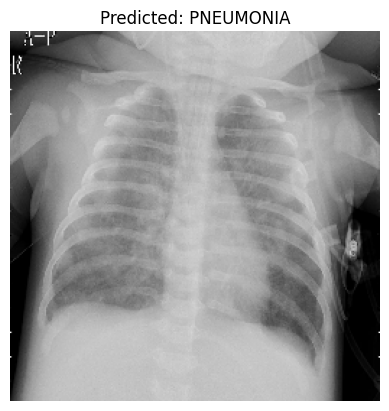

In [39]:
image_path = '/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'
predict_image(image_path)

In [40]:
y_pred=model.predict(val_ds)

2/2 [==============================] - 0s 9ms/step


In [41]:
print(y_pred)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
